# Initialization

all done with global python env 3.12.3 \
see requirements.txt - 27-09-2024 \

needs pyController module to control XRay Target

In [1]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as mp
import threading
import tango
import math
import json
import time
import sys

from serial.tools import list_ports

ports = list_ports.comports()
for port, desc, hwid in sorted(ports):
    print("{}: {} [{}]".format(port, desc, hwid))

COM_spin_arduino = 13
COM_stage_arduino = 17
COM_xyz_SMC100 = 5
COM_shutter_arduino = 4
COM_waveplate_AG_UC8 = 6

COM4: USB Serial Device (COM4) [USB VID:PID=2A03:0043 SER=75431343334351307190 LOCATION=1-9:x.0]
COM5: USB Serial Port (COM5) [USB VID:PID=0403:6001 SER=FT84J1IIA]
COM6: Newport AG-UC2-UC8 USB Serial Port (COM6) [USB VID:PID=104D:3000 SER=FTXEYTL6A]
COM8: XIMC Motor Controller (COM8) [USB VID:PID=1CBE:0007 SER=0000320E LOCATION=1-6:x.0]
COM9: XIMC Motor Controller (COM9) [USB VID:PID=1CBE:0007 SER=00003142 LOCATION=1-4.1:x.0]
COM10: XIMC Motor Controller (COM10) [USB VID:PID=1CBE:0007 SER=0000311C LOCATION=1-4.4:x.0]
COM13: USB-SERIAL CH340 (COM13) [USB VID:PID=1A86:7523 SER= LOCATION=1-11.4]
COM17: USB-SERIAL CH340 (COM17) [USB VID:PID=1A86:7523 SER= LOCATION=1-8:x.0]


### Init Target

In [64]:
from pyController.pyController import PyDuino

spin_aduino = PyDuino('COM' + str(COM_spin_arduino), timeout=1000)
stage_aduino = PyDuino('COM' + str(COM_stage_arduino), timeout=1000)

# spin_aduino.close()
# stage_aduino.close()

b'INITIALIZED\r\n'
b'INITIALIZED\r\n'


### Init Lens XYZ - SMC100

In [3]:
SMC100 = tango.DeviceProxy("voxel/SMC100/1")
print(SMC100.state())
SMC100.set_timeout_millis(120000)

userInfoController =    {
                            "Name"                  : "SC1",
                            "COM"                   : COM_xyz_SMC100,
                            "Number_of_controllers" : 3
                        }
userInfoController=json.dumps(userInfoController)
SMC100.ConnectCamera(userInfoController)

ON


'Controller has been connected successfully COM5'

In [4]:
MFA_1_AXEIS = 1
MFA_2_AXEIS = 2
MFA_3_AXEIS = 3

#################################
def SMC_move(userInfo):
    userInfo["Name"] = "SC1"
    userInfo["Wait_to_finish"] = True
    userInfo_string = json.dumps(userInfo)
    SMC100.MoveAbsolute_mm(userInfo_string)
    
def SMC_get_pos(userInfo):
    userInfo["Name"] = "SC1"
    userInfo_string = json.dumps(userInfo)
    return SMC100.GetPosition(userInfo_string)

#################################
def SMC_move_focus(pos):
    userInfo =    {}
    userInfo["Axis"] = MFA_1_AXEIS
    userInfo["Position"] = pos
    SMC_move(userInfo)

def SMC_get_focus():
    userInfo =    {}
    userInfo["Axis"] = MFA_1_AXEIS
    return SMC_get_pos(userInfo)

#################################
def SMC_move_x(pos):
    userInfo =    {}
    userInfo["Axis"] = MFA_2_AXEIS
    userInfo["Position"] = pos
    SMC_move(userInfo)

def SMC_get_x():
    userInfo =    {}
    userInfo["Axis"] = MFA_2_AXEIS
    return SMC_get_pos(userInfo)

#################################
def SMC_move_y(pos):
    userInfo =    {}
    userInfo["Axis"] = MFA_3_AXEIS
    userInfo["Position"] = pos
    SMC_move(userInfo)
    
def SMC_get_y():
    userInfo =    {}
    userInfo["Axis"] = MFA_3_AXEIS
    return SMC_get_pos(userInfo)

### Init Shutter

In [5]:
Arduino_Shutter = tango.DeviceProxy("voxel/Arduino_Shutter/1")
print(Arduino_Shutter.state())
Arduino_Shutter.set_timeout_millis(10000)

ArduinoInfo =   {
                    "Name"      : "AS1",
                    "COM"       : COM_shutter_arduino
                }
ArduinoInfo = json.dumps(ArduinoInfo)
Arduino_Shutter.Connect(ArduinoInfo)

Device_to_Open =    {
                        "Name"      : "AS1"
                    }
Device_to_Open_string = json.dumps(Device_to_Open)

ON


In [6]:
def open_shutter_for_seconds(duration):
    Arduino_Shutter.OpenShutter(Device_to_Open_string)
    time.sleep(duration)
    Arduino_Shutter.CloseShutter(Device_to_Open_string)

In [7]:
# Test shutter
time.sleep(1)
for i in range(10):
    Arduino_Shutter.OpenShutter(Device_to_Open_string)
    time.sleep(.1)
    Arduino_Shutter.CloseShutter(Device_to_Open_string)
    time.sleep(.05)

In [8]:
Arduino_Shutter.OpenShutter(Device_to_Open_string)

'On was executed\r\n'

In [9]:
Arduino_Shutter.CloseShutter(Device_to_Open_string)

'Off was executed\r\n'

In [10]:
# New metod 
Device_cicle =    {
                        "Name"      : "AS1",
                        "time_ms"   :  25,
                        "cicles"    :  10
                  }
Device_cicle_string = json.dumps(Device_cicle)
Arduino_Shutter.OperationShutter(Device_cicle_string)

'Cicle is going to be executed\r\n'

### Init Standa Motor

In [34]:
Standa = tango.DeviceProxy("voxel/StandaM/1")
print(Standa.state())
Standa.set_timeout_millis(120000)
Standa.set_device('8')
Standa.connection("open")
#Standa.get_list_diveces()
# Standa.get_command_list()

ON


'Connection established'

In [35]:
Standa_Vac_1 = tango.DeviceProxy("motor/standa/vacaxis1")
print(Standa_Vac_1.state())
Standa_Vac_1.set_timeout_millis(100000)
Standa_Vac_1.set_device('9')
Standa_Vac_1.connection("open")

ON


'Connection established'

In [36]:
Standa_Vac_2 = tango.DeviceProxy("motor/standa/vacaxis2")
print(Standa_Vac_2.state())
Standa_Vac_2.set_timeout_millis(120000)
Standa_Vac_2.set_device('10')
Standa_Vac_2.connection("open")

ON


'Connection established'

### Init Waveplate - AG UC8

In [14]:
N_AG_UC8 = tango.DeviceProxy("voxel/ag_uc8/1")
print(N_AG_UC8.state())

N_AG_UC8.set_timeout_millis(120000)

ON


In [15]:
AG_UC8 = {
            "Name"      : "Controller_1",
            "COM"       : COM_waveplate_AG_UC8,   
         }
AG_UC8 = json.dumps(AG_UC8)
print(N_AG_UC8.Connect(AG_UC8))

userinfoS = {
               "Name"      : "Controller_1",
               "Channel"   : 1,
               "Axis"      : 1 
            }
userinfoS = json.dumps(userinfoS)
N_AG_UC8.StatusMotor(userinfoS) == "ready"

ola


True

In [16]:
def AG_UC8_move_WP(steps):
    userinfoS = {}
    userinfoS["Name"] = "Controller_1"
    userinfoS["Channel"] = 1
    userinfoS["Axis"] = 1 
    userinfoS["Position"] = steps
    polaroide_string = json.dumps(userinfoS)
    N_AG_UC8.MoveRel(polaroide_string)


In [17]:
dir(N_AG_UC8)
N_AG_UC8.MeasurePosition(userinfoS)

'1000'

In [18]:
AG_UC8_move_WP(-30000)

### Init MiniPix

In [40]:
MiniPIX = tango.DeviceProxy("detector/minipix/tpx3")
print(MiniPIX.state())
MiniPIX.set_timeout_millis(120000)
# MiniPIX.ExposureTime = 2
# MiniPIX.Image

UNKNOWN


In [165]:
MiniPIX.ExposureTime = 5
img = MiniPIX.Image

Text(0.1, 0.9, 'cnts: 235131482')

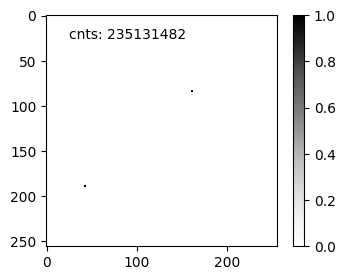

In [166]:
fig = plt.figure(figsize=(4,3))

gs00 = GridSpec(nrows = 1, ncols = 1)
ax = fig.add_subplot(gs00[0,0])

cbar = ax.imshow(img, cmap='Greys', aspect=1, vmin=0, vmax=1)
fig.colorbar(cbar, ax=ax)
ax.text(.1, 0.9, r'cnts: {:d}'.format(round(np.sum(img))), color='black', transform=ax.transAxes)

### Init Great Eyes

In [18]:
greateyesCCD = tango.DeviceProxy("voxel/greateyesCCD/1")
print(greateyesCCD.state())
greateyesCCD.set_timeout_millis(120000)

ON


In [19]:
greateyesCCD.get_command_list()

['Init', 'State', 'Status', 'get_foto_JSON', 'output_on_off']

In [20]:
greateyesCCD.get_attribute_list()

['current', 'noise', 'Image_foto', 'voltage', 'State', 'Status']

In [21]:
test_img1_reateyesCCD = json.loads(greateyesCCD.get_foto_JSON())
CCD_BG = np.array(test_img1_reateyesCCD["Image"])

44153.31884979783


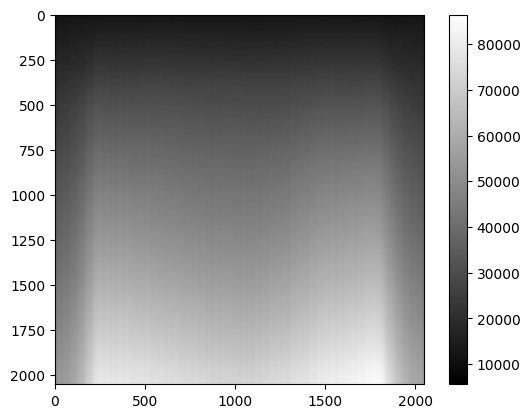

In [22]:
cbar = plt.imshow(CCD_BG, cmap="grey")
plt.colorbar(cbar)
print(np.mean(CCD_BG))

In [22]:
# test = greateyesCCD.get_foto_JSON()
# for i in range(3):
#     test=test+greateyesCCD.get_foto_JSON()
# test=test/4
# CCD_BG_test = np.array(json.loads(test)["Image"])
# cbar = plt.imshow(CCD_BG_test, cmap="grey")
# plt.colorbar(cbar)
# print(np.mean(CCD_BG_test))

In [23]:
#test_img2_reateyesCCD = np.array(greateyesCCD.Image_foto)
#plt.imshow(test_img2_reateyesCCD,cmap="grey")
#plt.colorbar()
#plt.show()

# Manual Scan

In [165]:
target_duration = 1.5 # in seconds
exposure = 1
steps = -1400 * target_duration# move target for little longer than the exposure
accell = 30 # time to accelerate in seconds (ca. 27s for defaul speed - see labbook)

"""
def acquire_data():
    MiniPIX.ExposureTime = 5
    try:
        return MiniPIX.Image
    except:
        print("MiniPix acquire failed")
        return np.zeros((256,256))
"""

def acquire_data():
    test_img1_reateyesCCD = json.loads(greateyesCCD.get_foto_JSON()) # takes ca 5 sec
    return np.array(test_img1_reateyesCCD["Image"]) - CCD_BG

def scan_step(value):
    SMC_move_y(value)

scan_list = np.linspace(11.5, 13.67, 4, endpoint=False)
print(scan_list)

[11.5    12.0425 12.585  13.1275]


In [188]:
def run_scan(debug=False):
    data = []
    data += [acquire_data()]
    if debug: print('background done')
    
    # Start Target Spinning
    timing_factor = 13 # experimentally set to have the target spin long enough
    spin_steps = timing_factor *((len(scan_list)+1)*(steps) + 1000*accell+30*1000)
    print(f"spinsteps={spin_steps}")
    spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', spin_steps, False,))
    spin_thread.start()
    time.sleep(accell)
    if debug: print("accell done")

    with tqdm(total=len(scan_list)+1, position=0, bar_format="{l_bar}{bar} [time left: {remaining}, time spent: {elapsed}]") as pbar:
        for i in range(len(scan_list)+1):
            # Start Target Translation
            stage_thread = threading.Thread(target=stage_aduino.set_value, args=('M', 'X', steps*-4, False,))
            stage_thread.start()
            time.sleep(1.5)# originally 0.2

            shutter_thread = threading.Thread(target=open_shutter_for_seconds, args=(exposure,))

            # Open Laser Shutter
            shutter_thread.start()
            # Arduino_Shutter.OpenShutter(Device_to_Open_string)
            if debug: print('Shutter open')

            # Aquire Data
            data += [acquire_data()]
            if debug: print('acquire done')

            stage_thread.join() # waits till translation is done
            if debug: print('stage done')

            # Close Laser Shutter
            # Arduino_Shutter.CloseShutter(Device_to_Open_string)
            # if debug: print('Shutter close')

            # Scan Parameter
            if i < len(scan_list):
                scan_step(scan_list[i])
                if debug: print('step done')
            
            pbar.update(1)

    # Wait Till Spin Stops
    spin_thread.join()
    if debug: print("spin done")

    return np.array(data)

In [191]:
stage_thread = threading.Thread(target=stage_aduino.set_value, args=('M', 'X', 5*steps, False,))
stage_thread.start()
stage_thread.join()

In [189]:
data_scan = run_scan(debug=True)
print(np.shape(data_scan))
print(np.amax(data_scan))

background done
spinsteps=643500.0
accell done


  0%|           [time left: ?, time spent: 00:00]

Shutter open
acquire done
stage done


 20%|██         [time left: 01:02, time spent: 00:15]

step done
Shutter open
acquire done
stage done


 40%|████       [time left: 00:39, time spent: 00:27]

step done
Shutter open
acquire done
stage done


 60%|██████     [time left: 00:25, time spent: 00:39]

step done
Shutter open
acquire done
stage done


 80%|████████   [time left: 00:12, time spent: 00:50]

step done
Shutter open
acquire done


100%|██████████ [time left: 00:00, time spent: 01:00]

stage done
spin done
(6, 2052, 2048)
3581


# Plot Scan

### MiniPix

In [ ]:
fig = plt.figure(figsize=(7,5))

plt.subplots_adjust(wspace = 0.05, hspace = 0.25)

grid_size = math.ceil(np.sqrt(len(data_scan)))
gs00 = GridSpec(nrows = grid_size, ncols = grid_size)

nrows, ncols = gs00.get_geometry()
axes = []
for i in range(nrows):
    for j in range(ncols):
        axes += [fig.add_subplot(gs00[i,j])]
        if j > 0:
            axes[-1].get_yaxis().set_visible(False)
        if i < nrows-1:
            axes[-1].get_xaxis().set_visible(False)

vmax=1 #np.amax(data_scan)

for i in range(len(data_scan)):
    ax = axes[i]
    img = data_scan[i]
    cbar = ax.imshow(img, cmap='Greys', aspect=1, vmin=0, vmax=vmax)
    fig.colorbar(cbar, ax=ax)

    counts = img.sum()
    ax.text(.3, .8, r'cnts: {:d}'.format(round(counts)), color='white', transform=ax.transAxes)
    
    ax.set_title([["start"] + scan_list][i])

### Greateyes CCD

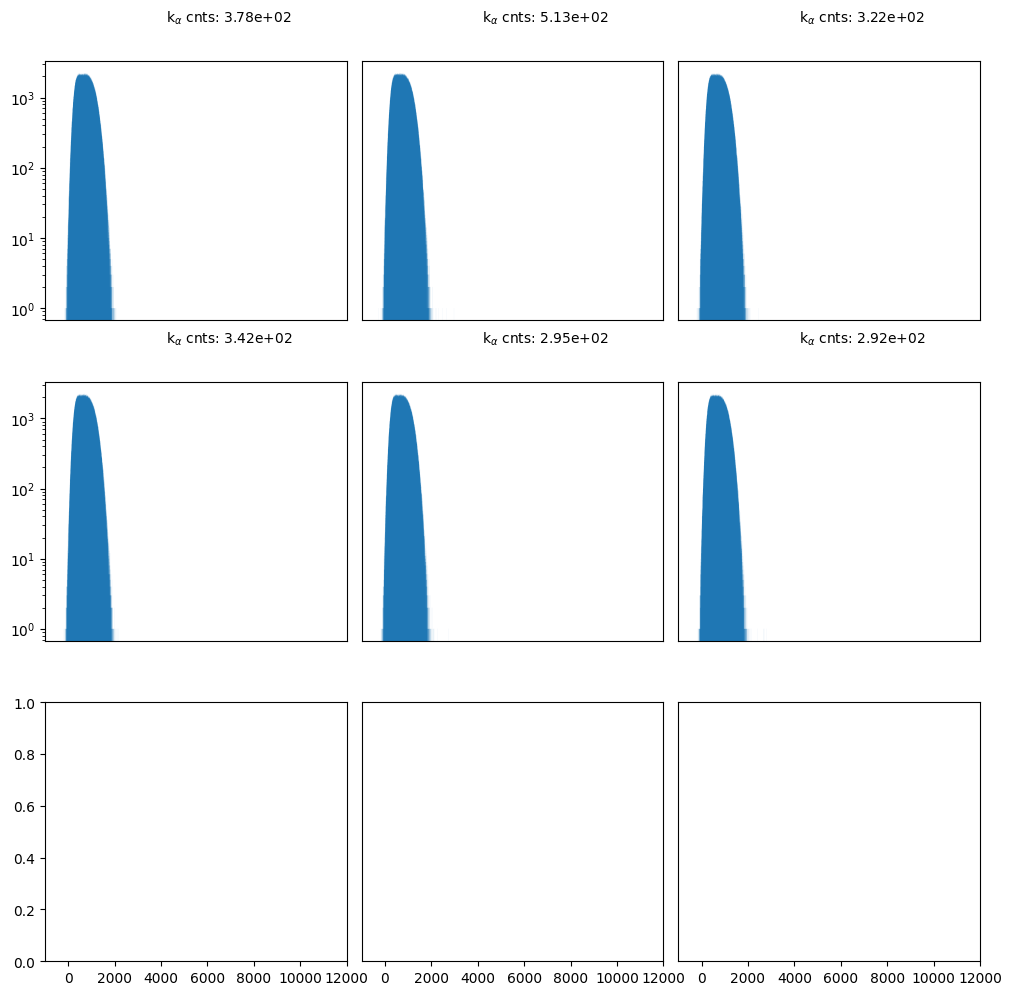

In [74]:
fig = plt.figure(figsize=(10,10))

plt.subplots_adjust(wspace = 0.05, hspace = 0.25)

grid_size = math.ceil(np.sqrt(len(data_scan)))
gs00 = GridSpec(nrows = grid_size, ncols = grid_size)

nrows, ncols = gs00.get_geometry()
axes = []
for i in range(nrows):
    for j in range(ncols):
        axes += [fig.add_subplot(gs00[i,j])]
        if j > 0:
            axes[-1].get_yaxis().set_visible(False)
        if i < nrows-1:
            axes[-1].get_xaxis().set_visible(False)
        
        axes[-1].set_xlim(-1000, 12000)

name_scan_list = [str(pos) for pos in scan_list]
for i in range(len(data_scan)):
    ax = axes[i]
    img = data_scan[i,:2048//2,:]
    arr = img.flatten()
    
    ax.hist(arr, bins=np.arange(np.amin(img), np.amax(img), dtype=int), histtype='stepfilled')
    
    #cbar = ax.imshow(img, cmap='Greys', aspect=1)
    #fig.colorbar(cbar, ax=ax)
    
    name = (["BG","Inital"] + name_scan_list)[i]
    #ax.text(0, 1.15, r'scan: ' + name, transform=ax.transAxes)
    counts = ((0 > arr)).sum() - ((0 < arr)).sum()
    #ax.text(.4, 1.05, r'sig. cnts: {:.2e}'.format(counts), transform=ax.transAxes)
    counts = ((1800 < arr) & (arr < 2500)).sum()
    ax.text(.4, 1.15, r'k$_\alpha$ cnts: {:.2e}'.format(counts), transform=ax.transAxes)
    
    ax.set_yscale("log")
fig.tight_layout()
#fig.savefig(str(time.time()) + ".pdf")

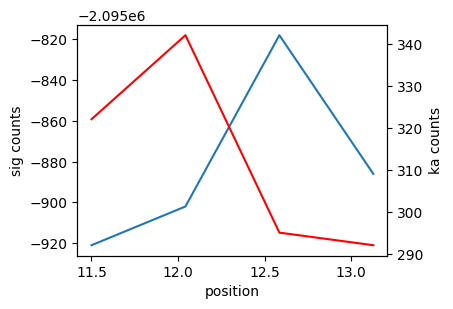

In [75]:
if len(scan_list) > 0:
    fig = plt.figure(figsize=(4,3))

    plt.subplots_adjust(wspace = 0.05, hspace = 0.25)
    gs00 = GridSpec(nrows = 1, ncols = 1)
    ax = fig.add_subplot(gs00[0,0])
    ax02 = ax.twinx()

    arr_sig_count = np.zeros(len(data_scan))
    arr_ka_count = np.zeros(len(data_scan))
    for i in range(len(data_scan)):
        img = data_scan[i,:2048//2,:]
        arr = img.flatten()

        arr_sig_count[i] = ((0 > arr)).sum() - ((0 < arr)).sum()
        arr_ka_count[i] = ((1800 < arr) & (arr < 2500)).sum()

    ax.plot(scan_list, arr_sig_count[2:])
    ax02.plot(scan_list, arr_ka_count[2:], color="red")

    ax.set_xlabel("position")
    ax.set_ylabel("sig counts")
    ax02.set_ylabel("ka counts")

    fig.savefig(str(time.time()) + ".pdf")

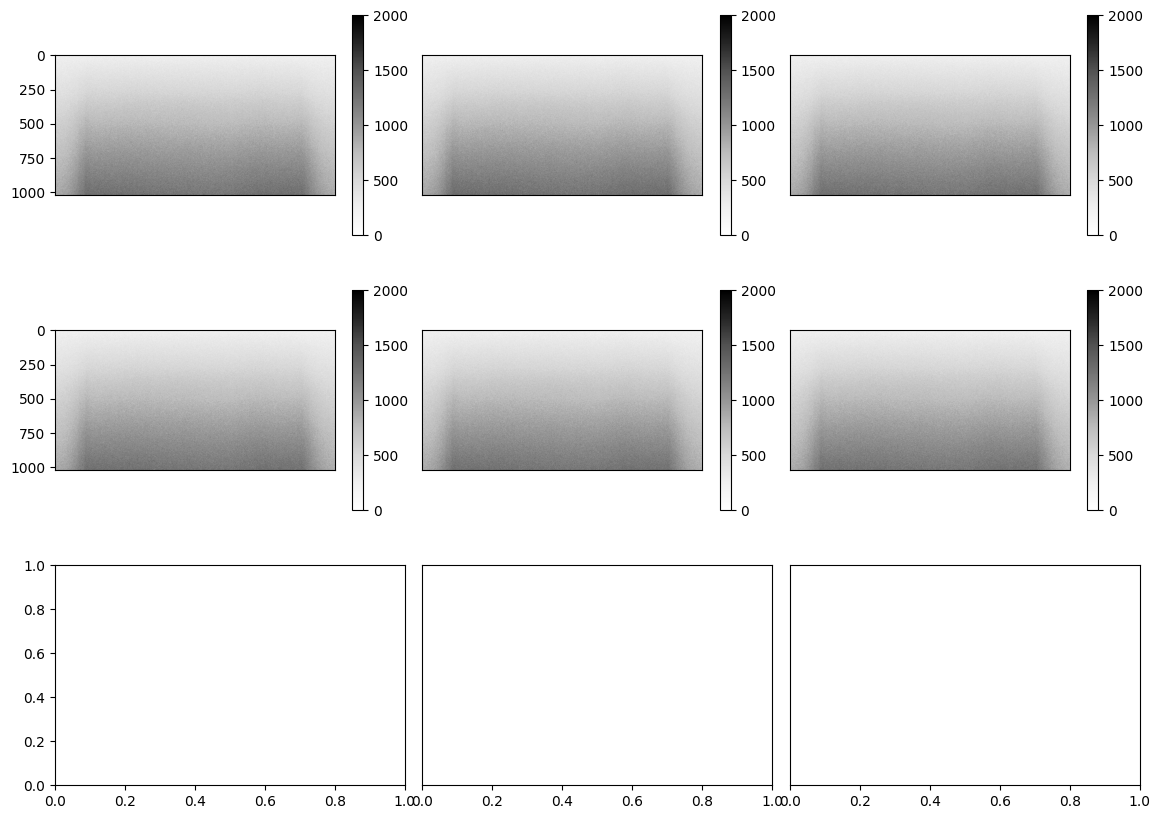

In [76]:
fig = plt.figure(figsize=(14,10))

plt.subplots_adjust(wspace = 0.05, hspace = 0.25)

grid_size = math.ceil(np.sqrt(len(data_scan)))
gs00 = GridSpec(nrows = grid_size, ncols = grid_size)

nrows, ncols = gs00.get_geometry()
axes = []
for i in range(nrows):
    for j in range(ncols):
        axes += [fig.add_subplot(gs00[i,j])]
        if j > 0:
            axes[-1].get_yaxis().set_visible(False)
        if i < nrows-1:
            axes[-1].get_xaxis().set_visible(False)

for i in range(len(data_scan)):
    ax = axes[i]
    img = data_scan[i,:2048//2,:]

    cbar = ax.imshow(img, cmap='Greys', aspect=1, vmin=0, vmax=2000)
    fig.colorbar(cbar, ax=ax)

# Optimization

In [37]:
from skopt import gp_minimize 
from skopt.space import Real 

In [38]:
# loss function
def gain_func(image):
    arr = image.flatten()
    return ((1800 < arr) & (arr < 2500)).sum()

In [39]:
def acquire_optim_data():
    test_img1_reateyesCCD = json.loads(greateyesCCD.get_foto_JSON()) # takes ca 5 sec, 10ms exposure
    return np.array(test_img1_reateyesCCD["Image"]) - CCD_BG

def single_step(steps, exposure=1.5):
    
    # Start Target Spin
    ###spin_aduino.set_value("T","X",60,False)
    ###spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', 8*1000*4*60, False,))#8*1000*4*60
    ###spin_thread.start()
    ###time.sleep(.1)

    # Start Target Translation
    stage_aduino.set_value("T","X",500,False)
    stage_thread = threading.Thread(target=stage_aduino.set_value, args=('M', 'X', steps, False,))
    stage_thread.start()
    time.sleep(1.35)#originally 0.05
    
    # Open Laser Shutter
    shutter_thread = threading.Thread(target=open_shutter_for_seconds, args=(exposure,))
    shutter_thread.start()

    # Aquire Data
    img = acquire_optim_data()

    shutter_thread.join()
    stage_thread.join() # waits till translation is done
    ###spin_thread.join() # waits till spin is done

    return img#gain_func(img), 

In [199]:
spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', 1*1000*30+5*13*1000*60, False,))#8*1000*4*60
spin_thread.start()
spin_thread.join()

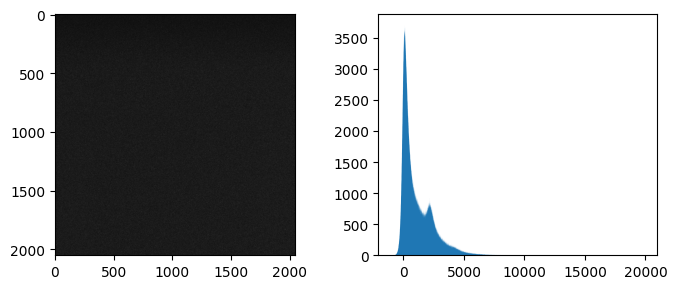

In [245]:
### - Single shot - ###

cameraexp=1

exposure=0.5+cameraexp
target_duration=0.5+exposure


steps = -1400 * target_duration

#[15.42918900720279, 11.636632747961153, 13.459470628035435]
SMC_move_focus(15.43)
SMC_move_x(11.64)
SMC_move_y(13.46)

test_img1_reateyesCCD = json.loads(greateyesCCD.get_foto_JSON())
CCD_BG = np.array(test_img1_reateyesCCD["Image"])

spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', 1*1000*30+0.3*13*1000*60, False,))#8*1000*4*60
spin_thread.start()
time.sleep(35)

stage_aduino.set_value("T","X",500,False)
stage_thread = threading.Thread(target=stage_aduino.set_value, args=('M', 'X', steps, False,))
stage_thread.start()
time.sleep(1.35)#originally 0.05
    
# Open Laser Shutter
shutter_thread = threading.Thread(target=open_shutter_for_seconds, args=(exposure,))
shutter_thread.start()

# Aquire Data
img = acquire_optim_data()

shutter_thread.join()
stage_thread.join()
spin_thread.join()

arr = img.flatten()
fig, axs = plt.subplots(1,2,figsize=(7,3))
axs[0].imshow(img, cmap="grey")
axs[1].hist(arr, bins=np.arange(np.amin(img), np.amax(img), dtype=int), histtype='stepfilled')
fig.tight_layout()
#fig.savefig("single_shot"+ str(gain_func(img)) +".png")
np.savetxt("1x1bin"+str(cameraexp)+"sexp" +".txt", img)


In [144]:
time.sleep(5)
single_step(500)

array([[  86,   29,  -50, ...,  -52,   -7,  -20],
       [ -66,  -50,    9, ...,  -71,   27,  128],
       [  51,  114, -142, ...,   40, -101,  -32],
       ...,
       [-126,  309,   67, ...,  -11,   59, -300],
       [  72,  478,  -16, ...,  -39,  -77,  159],
       [-279,  402,   11, ...,  183,  150,   97]])

In [293]:
ka_array = []
rnts = 15
with tqdm(rnts, bar_format="{l_bar}{bar} [time left: {remaining}, time spent: {elapsed}]") as pbar:
    for i in range(rnts):
        ka, img = single_step(1000*.5)
        ka_array += [ka]
        pbar.update(1)

|           [time left: ?, time spent: 00:00]

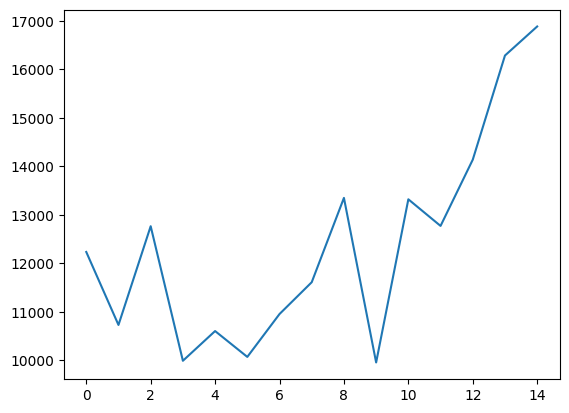

In [294]:
plt.plot(ka_array)

In [26]:
def acquire_optim_data1():
    Arduino_Shutter.OpenShutter(Device_to_Open_string)
    time.sleep(0.1)
    test_img1_reateyesCCD = json.loads(greateyesCCD.get_foto_JSON()) # takes ca 5 sec, 10ms exposure
    Arduino_Shutter.CloseShutter(Device_to_Open_string)
    return np.array(test_img1_reateyesCCD["Image"]) - CCD_BG

def single_step1(steps, exposure=1.5):
    
    # Start Target Spin
    ###spin_aduino.set_value("T","X",60,False)
    ###spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', 8*1000*4*60, False,))#8*1000*4*60
    ###spin_thread.start()
    ###time.sleep(.1)

    # Start Target Translation
    stage_aduino.set_value("T","X",500,False)
    stage_thread = threading.Thread(target=stage_aduino.set_value, args=('M', 'X', steps, False,))
    stage_thread.start()
    time.sleep(1.35)#originally 0.05

    # Aquire Data
    img = acquire_optim_data()   

    # Open Laser Shutter
    ###shutter_thread = threading.Thread(target=open_shutter_for_seconds, args=(exposure,))
    ###shutter_thread.start()



    ###shutter_thread.join()
    stage_thread.join() # waits till translation is done
    ###spin_thread.join() # waits till spin is done

    return gain_func(img), img

In [139]:
time.sleep(5)
ka, img = single_step(1000*.5)

ValueError: too many values to unpack (expected 2)

In [ ]:
spin_steps =
spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', spin_steps, False,))
spin_thread.start()

# Define the parameter space: lens positions (x, y, z), target (x), polarizer (angle) 
space = [
    Real(16, 18.5, name='lens_focus'),      # Lens focus-position 
    Real(9, 11, name='lens_y'),      # Lens y-position 
    Real(11, 13, name='lens_z'),      # Lens z-position 
    #Real(0, 20, name='target_x'),      # Target x-position 
    #Real(0, np.pi, name='polarizer_angle')  # Polarizer angle in radians 
] 

# Objective function that simulates an experiment 
def objective_function(params): 
    lens_x, lens_y, lens_z = params 

    # Simulate running your experiment with these parameters 
    print(f"Running experiment with lens_x={lens_x}, lens_y={lens_y}, lens_z={lens_z}") 
    single_step()
    # Here, you would call your actual experiment functions: 
    # move_lens_to(lens_x, lens_y, lens_z) 
    # move_target_to(target_x) 
    # rotate_polarizer_to(polarizer_angle) 

    # Simulate measuring the result (replace this with actual data from the experiment) 
    time.sleep(1)  # Simulating the time it takes for the experiment 
    measured_signal = np.random.random()  # Replace with your actual measurement 

    print(f"Measured signal: {measured_signal}") 

    # Return the negative signal because skopt minimizes functions 
    return -measured_signal 


# Running Bayesian optimization with n_calls=30 and random_state=42 
# n_calls = number of evaluations of the objective function (i.e., how many experiments to run) 
# random_state = fixed seed for the random number generator to ensure reproducibility 

# Setting n_calls=30 means we will run the experiment 30 times with different parameter configurations suggested by the optimizer. 
# Setting random_state=42 ensures that we get the same parameter suggestions every time we run this code, making the results reproducible. 

res = gp_minimize(objective_function, space, n_calls=30, random_state=42) 

# Print the best parameters found 
best_params = res.x 
best_signal = -res.fun  # Flip the sign to get the actual signal 
print("Best parameters found:", best_params) 
print("Best signal value:", best_signal) 

# Here’s why we used the following: 
# - n_calls=30: This means the optimizer will run the objective function 30 times, each time suggesting new parameters to test. 
# - random_state=42: This ensures that every time you run the code, the results will be the same, which is useful for reproducibility. 
#   You can change this to another number if you want, or leave it out entirely if you don't need reproducibility. 

In [ ]:
#spin_steps = 1000*0.5
#spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', spin_steps, False,))
#spin_thread.start()



measuredsignalvec=[]
previous_angle=[0]

iterations=10

# Define the parameter space: lens positions (x, y, z), target (x), polarizer (angle) 
space = [
    Real(16, 18.5, name='lens_focus'),      # Lens focus-position 
    Real(9, 11, name='lens_y'),      # Lens y-position 
    Real(11, 13, name='lens_z'),      # Lens z-position 
    #Real(33000, 380000, name='target_x'),      # Target x-position 
    Real(0, 30000, name='polarizer_angle')  # Polarizer angle in steps 
] 

# Objective function that simulates an experiment 
def objective_function(params): 
    lens_x, lens_y, lens_z, polarizer_angle= params #target_x

    # Simulate running your experiment with these parameters
    iteration_number=len(measuredsignalvec)+1
    print(f"Running experiment {iteration_number}/{iterations} with lens_x={lens_x}, lens_y={lens_y}, lens_z={lens_z}, polarizer_angle={polarizer_angle}")#target_x={target_x}, 
    
    # Convert from absolute angle to relative angle for correct waveplate-input
    difference_angle=polarizer_angle-previous_angle[-1]
    previous_angle.append(previous_angle[-1]+difference_angle)
    if difference_angle<0:
        difference_angle=difference_angle*(1-30/360)    #correcting for difference in positive and negative direction output, with a deviation of about 30 deg per 360 deg in the negative direction

    # Actual experiment functions: 
    SMC_move_focus(lens_x)
    SMC_move_x(lens_y)
    SMC_move_y(lens_z)
    AG_UC8_move_WP(difference_angle)
    time.sleep(math.ceil(abs(difference_angle)*1.5/1000)+1)
    #Standa_Vac_2.move_to(target_x)
    

    single_step(1000*.5)
    

    measured_signal = gain_func(img)

    measuredsignalvec.append(measured_signal)
    if len(measuredsignalvec)==iterations:
        mp.plot(measuredsignalvec)
        
    
    print(f"Measured signal: {measured_signal}") 

    # Return the negative signal because skopt minimizes functions 
    return -measured_signal



# Running Bayesian optimization with n_calls=30 and random_state=42 
# n_calls = number of evaluations of the objective function (i.e., how many experiments to run) 
# random_state = fixed seed for the random number generator to ensure reproducibility 

# Setting n_calls=30 means we will run the experiment 30 times with different parameter configurations suggested by the optimizer. 
# Setting random_state=42 ensures that we get the same parameter suggestions every time we run this code, making the results reproducible. 

res = gp_minimize(objective_function, space, n_calls=iterations, random_state=42) 

# Print the best parameters found 
best_params = res.x 
best_signal = -res.fun  # Flip the sign to get the actual signal 
print("Best parameters found:", best_params) 
print("Best signal value:", best_signal) 

mp.show()

# Here’s why we used the following: 
# - n_calls=30: This means the optimizer will run the objective function 30 times, each time suggesting new parameters to test. 
# - random_state=42: This ensures that every time you run the code, the results will be the same, which is useful for reproducibility. 
#   You can change this to another number if you want, or leave it out entirely if you don't need reproducibility. 

Running experiment 1/10 with lens_x=17.991357467150582, lens_y=9.366869579732327, lens_z=12.55938200054554, polarizer_angle=17905.504738394615


Running experiment 1/10 with polarizer_angle=26.85825710759192
929.7402241429855


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 273 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


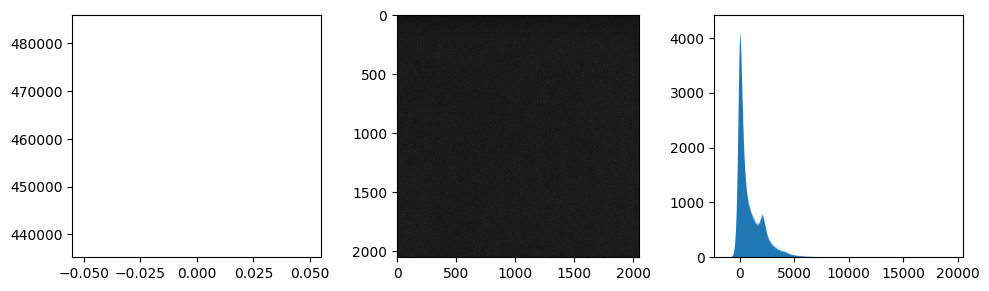

Measured signal: 460556
Running experiment 2/10 with polarizer_angle=15.016887501255985
887.4571416605751


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 274 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


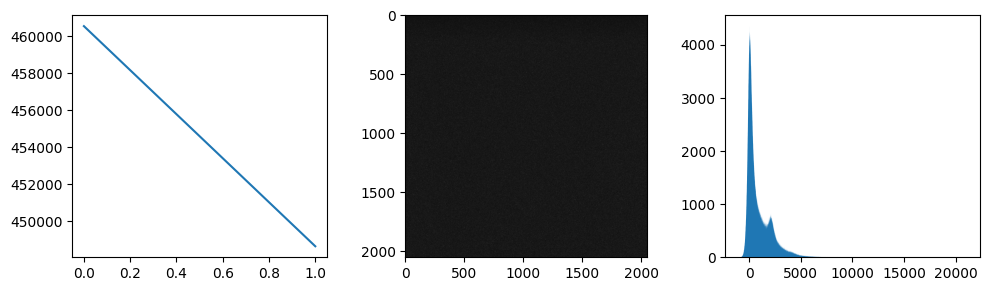

Measured signal: 448642
Running experiment 3/10 with polarizer_angle=32.48994475200712
860.3785124364188


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 275 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


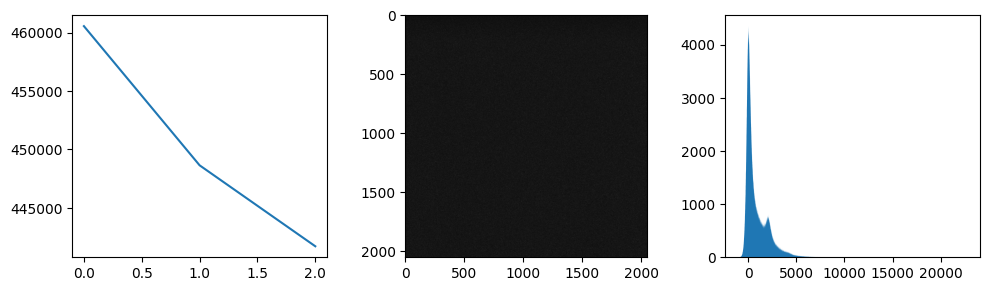

Measured signal: 441711
Running experiment 4/10 with polarizer_angle=27.786667933247248
940.4350371779057


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 276 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


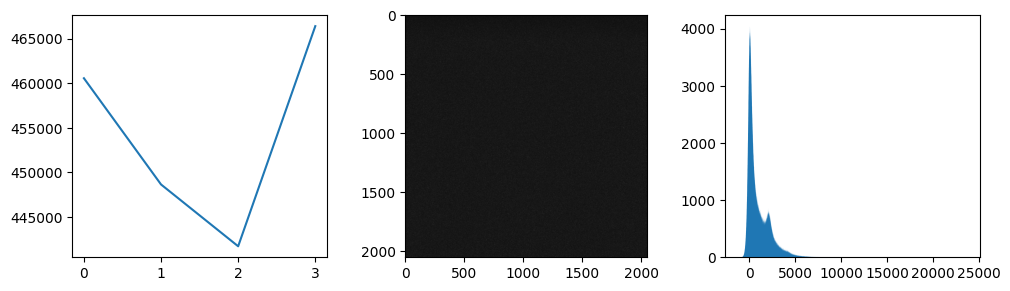

Measured signal: 466399
Running experiment 5/10 with polarizer_angle=23.614859711627517
890.717158326861


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 277 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


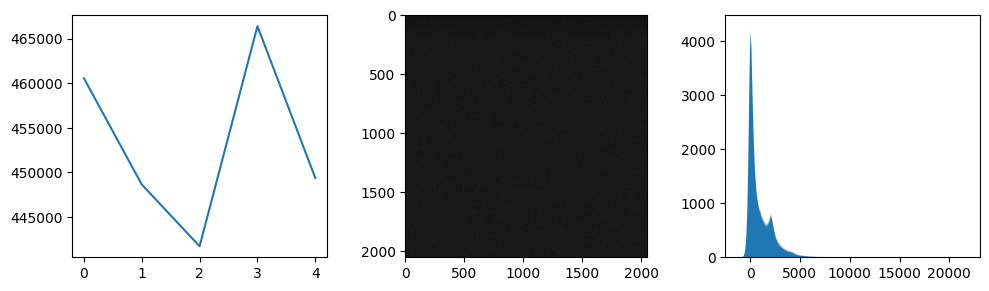

Measured signal: 449377
Running experiment 6/10 with polarizer_angle=10.474710319363693
987.1556734378808


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 278 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


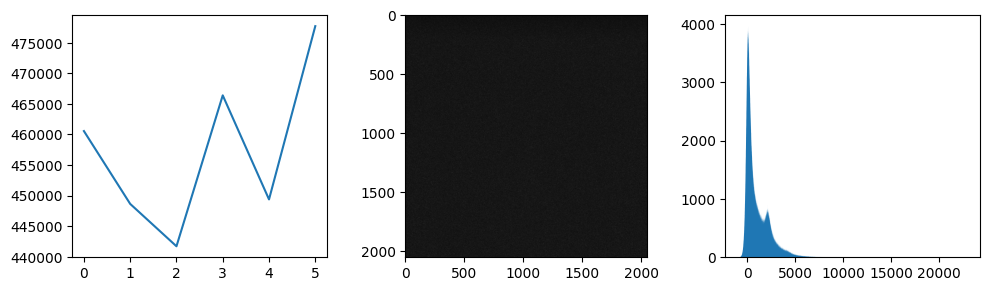

Measured signal: 477720
Running experiment 7/10 with polarizer_angle=44.245389861305476
953.0169768156828


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 279 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


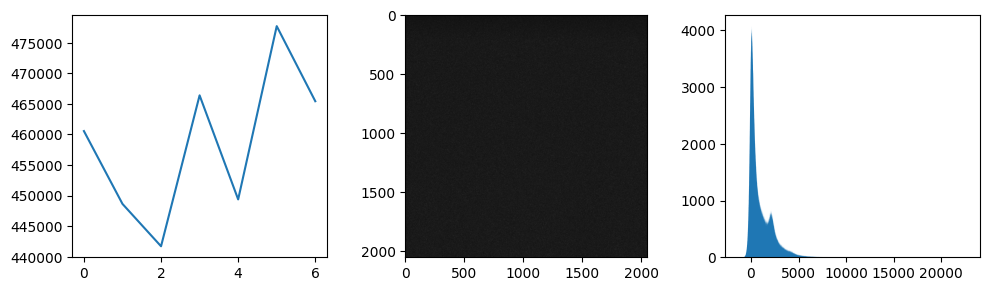

Measured signal: 465438
Running experiment 8/10 with polarizer_angle=20.27246633862944
972.2398139105903


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 280 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


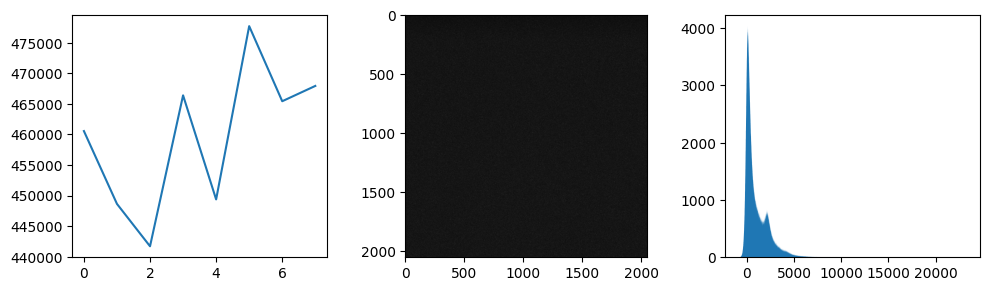

Measured signal: 467940
Running experiment 9/10 with polarizer_angle=17.34374261429623
1039.3087231968811


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 281 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


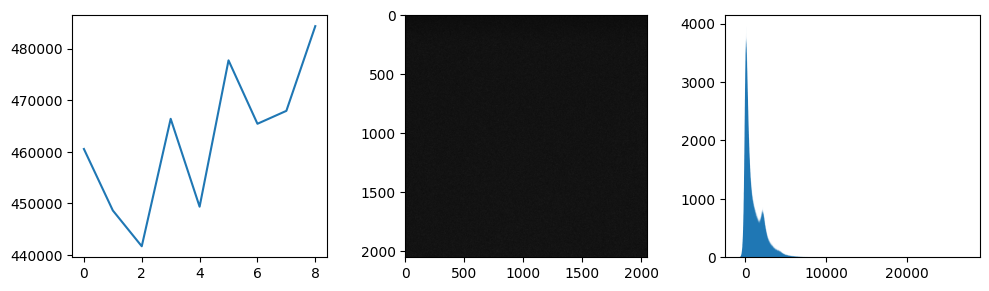

Measured signal: 484347
Running experiment 10/10 with polarizer_angle=30.746858347145626
945.4107182969359


C:\Users\Voxel\AppData\Local\Temp\ipykernel_12028\2959683143.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 282 Axes> than <Figure size 1000x300 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(cbar)


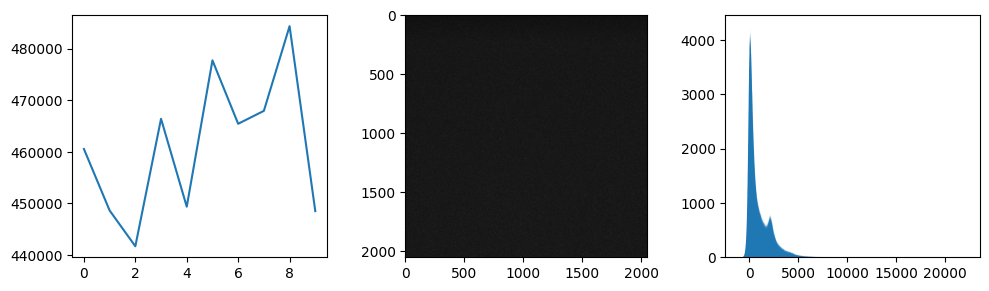

Measured signal: 448516
Best parameters found: [17.34374261429623]
Best signal value: 484347


In [75]:
### - Working optimization script - ###

iterations=10

SMC_move_focus(15.55)
SMC_move_x(11.62)
SMC_move_y(14.90)

#SMC_move_focus(15.45)
#SMC_move_x(11.34)
#SMC_move_y(12.30)

#SMC_move_focus(17)
#SMC_move_x(13)
#SMC_move_y(12.5)

target_duration = 1.5 # in seconds
exposure = 1
steps = -1400 * target_duration # move target for little longer than the exposure
accell = 30 # time to accelerate in seconds (ca. 27s for defaul speed - see labbook)

timing_factor = 13 # experimentally set to have the target spin long enough
spin_steps1 = timing_factor *((iterations+1)*(steps) + 1000*accell+5*60*1000)#6 for ten iterations      +6*60*1000#6 for 20, 10 for 30?
spin_steps = 1*30*1000+5*60*1000*13#21 for 40 it
#print(f"spinsteps={spin_steps}")
spin_thread = threading.Thread(target=spin_aduino.set_value, args=('M', 'X', spin_steps, False,))
spin_thread.start()
time.sleep(accell)

measuredsignalvec=[]
previous_angle=[0]
data = []

test_img1_reateyesCCD = json.loads(greateyesCCD.get_foto_JSON())
CCD_BG = np.array(test_img1_reateyesCCD["Image"])

# Define the parameter space: lens positions (x, y, z), target (x), polarizer (angle) 
space = [
    Real(15, 16, name='lens_focus'),      # Lens focus-position 
    Real(11, 12, name='lens_y'),      # Lens y-position 
    Real(13, 20, name='lens_z'),      # Lens z-position 
    #Real(33000, 380000, name='target_x'),      # Target x-position 
    Real(0, 45, name='polarizer_angle')  # Polarizer angle in steps 
] 

# Objective function that simulates an experiment 
def objective_function(params): 
    lens_x, lens_y, lens_z, polarizer_angle= params #target_x  

    
    # Simulate running your experiment with these parameters
    iteration_number=len(measuredsignalvec)+1
    print(f"Running experiment {iteration_number}/{iterations} with polarizer_angle={polarizer_angle}")#target_x={target_x}, lens_x={lens_x}, lens_y={lens_y}, lens_z={lens_z} , polarizer_angle={polarizer_angle*1.5/1000}
    
    # Convert from absolute angle to relative angle for correct waveplate-input
    difference_angle=polarizer_angle-previous_angle[-1]
    previous_angle.append(previous_angle[-1]+difference_angle)
    if difference_angle<0:
        difference_angle=difference_angle*(1-30/360)    #correcting for difference in positive and negative direction output, with a deviation of about 30 deg per 360 deg in the negative direction
    else:
        difference_angle=difference_angle*(1+3/60)
    nothing=lens_x+lens_y+lens_z+difference_angle
    # Actual experiment functions: 
    #SMC_move_focus(lens_x)
    #SMC_move_x(lens_y)
    #SMC_move_y(lens_z)
    #AG_UC8_move_WP(difference_angle)
    #time.sleep(math.ceil(abs(difference_angle)*1.5/1000)+1)
    #Standa_Vac_2.move_to(target_x)
    #print(f"You have 22 seconds to move the target to {polarizer_angle}")
    #time.sleep(22)

    stage_aduino.set_value("T","X",500,False)
    stage_thread = threading.Thread(target=stage_aduino.set_value, args=('M', 'X', 500, False,))
    stage_thread.start()
    time.sleep(1.35)#originally 0.05
    
    # Open Laser Shutter
    shutter_thread = threading.Thread(target=open_shutter_for_seconds, args=(exposure,))
    shutter_thread.start()

    # Aquire Data
    image=acquire_optim_data()
    measured_signal = gain_func(image)

    shutter_thread.join()
    stage_thread.join()
    measuredsignalvec.append(measured_signal)    
    #single_step(steps)

    # data.append(img)
    
    arr = image.flatten()
    fig, axs = plt.subplots(1,3,figsize=(10,3))
    axs[0].plot(measuredsignalvec)
    axs[1].imshow(image, cmap="grey")
    axs[2].hist(arr, bins=np.arange(np.amin(image), np.amax(image), dtype=int), histtype='stepfilled')
    print(np.mean(image))
    plt.colorbar(cbar)
    fig.tight_layout()
    mp.show()

        
    
    print(f"Measured signal: {measured_signal}") 

    # Return the negative signal because skopt minimizes functions 
    return -measured_signal

# Running Bayesian optimization with n_calls=30 and random_state=42 
# n_calls = number of evaluations of the objective function (i.e., how many experiments to run) 
# random_state = fixed seed for the random number generator to ensure reproducibility 

# Setting n_calls=30 means we will run the experiment 30 times with different parameter configurations suggested by the optimizer. 
# Setting random_state=42 ensures that we get the same parameter suggestions every time we run this code, making the results reproducible. 

res = gp_minimize(objective_function, space, n_calls=iterations, random_state=42) 


spin_thread.join()
# Print the best parameters found 
best_params = [res.x[3]]#[res.x[0], res.x[1], res.x[2]]# , res.x[3]*1.5/1000
best_signal = -res.fun  # Flip the sign to get the actual signal 
print("Best parameters found:", best_params) 
print("Best signal value:", best_signal) 



# Here’s why we used the following: 
# - n_calls=30: This means the optimizer will run the objective function 30 times, each time suggesting new parameters to test. 
# - random_state=42: This ensures that every time you run the code, the results will be the same, which is useful for reproducibility. 
#   You can change this to another number if you want, or leave it out entirely if you don't need reproducibility. 

In [45]:
#np.save('test3.npy', a)
tobesaved=[-res.func_vals,np.transpose(res.x_iters)[0], np.transpose(res.x_iters)[1], np.transpose(res.x_iters)[2]]
np.savetxt(str(iterations)+"iter"+ str(max(-res.func_vals)) +"maxsignal"+ ".txt", tobesaved)
#tobesaved[0]

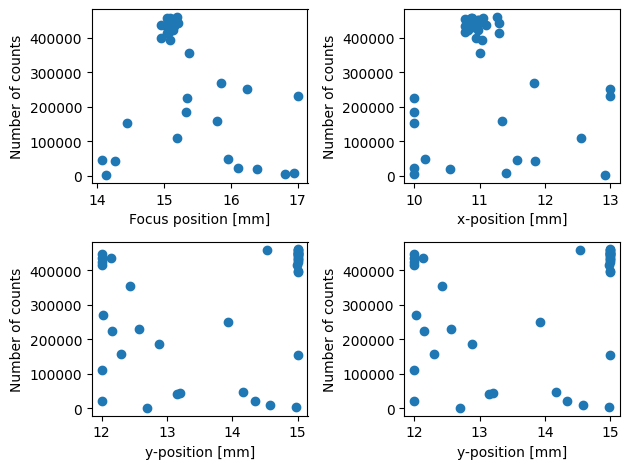

In [41]:
focus_inputs=np.transpose(res.x_iters)[0]
x_inputs=np.transpose(res.x_iters)[1]
y_inputs=np.transpose(res.x_iters)[2]
#angle_inputs=np.transpose(res.x_iters)[3]


fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(focus_inputs,-res.func_vals)
axs[0, 0].set(xlabel='Focus position [mm]', ylabel='Number of counts')

axs[0, 1].scatter(x_inputs,-res.func_vals)
axs[0, 1].set(xlabel='x-position [mm]', ylabel='Number of counts')

axs[1, 0].scatter(y_inputs,-res.func_vals)
axs[1, 0].set(xlabel='y-position [mm]', ylabel='Number of counts')

axs[1, 1].scatter(y_inputs,-res.func_vals)
axs[1, 1].set(xlabel='y-position [mm]', ylabel='Number of counts')

#axs[1, 1].scatter(angle_inputs*1.5/1000,-res.func_vals)
#axs[1, 1].set(xlabel='Waveplate angle [°]', ylabel='Number of counts')
fig.tight_layout()


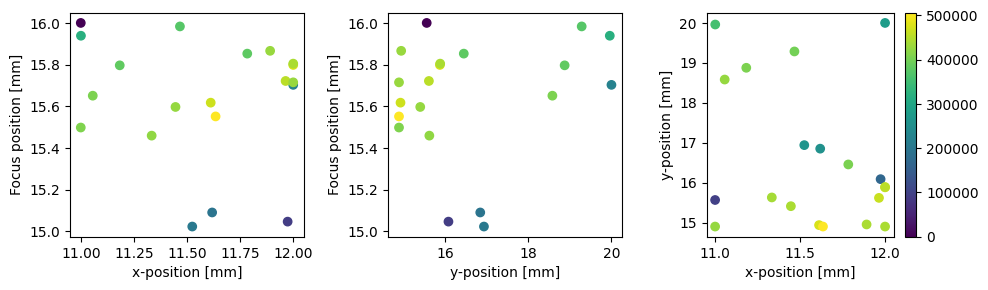

In [46]:
focus_inputs=np.transpose(res.x_iters)[0]
x_inputs=np.transpose(res.x_iters)[1]
y_inputs=np.transpose(res.x_iters)[2]
#angle_inputs=np.transpose(res.x_iters)[3]


fig, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].scatter(x_inputs,focus_inputs,c=-res.func_vals)
axs[0].set(xlabel='x-position [mm]', ylabel='Focus position [mm]')
axs[0].tick_params(axis="y",direction="in")
axs[0].tick_params(axis="x",direction="in")

axs[1].scatter(y_inputs,focus_inputs,c=-res.func_vals)
axs[1].set(xlabel='y-position [mm]', ylabel='Focus position [mm]')
axs[1].tick_params(axis="y",direction="in")
axs[1].tick_params(axis="x",direction="in")

third=axs[2].scatter(x_inputs,y_inputs,c=-res.func_vals, vmin=0, vmax=max(-res.func_vals))
axs[2].set(xlabel='x-position [mm]', ylabel='y-position [mm]')
axs[2].tick_params(axis="y",direction="in")
axs[2].tick_params(axis="x",direction="in")
plt.colorbar(third) 

#axs[1, 1].scatter(angle_inputs*1.5/1000,-res.func_vals)
#axs[1, 1].set(xlabel='Waveplate angle [°]', ylabel='Number of counts')

fig.tight_layout()
fig.savefig(str(iterations)+"iter"+ str(max(-res.func_vals)) +"maxsignal"+".pdf")

In [36]:
x_inputs[:0+1]

array([9.73373916])

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


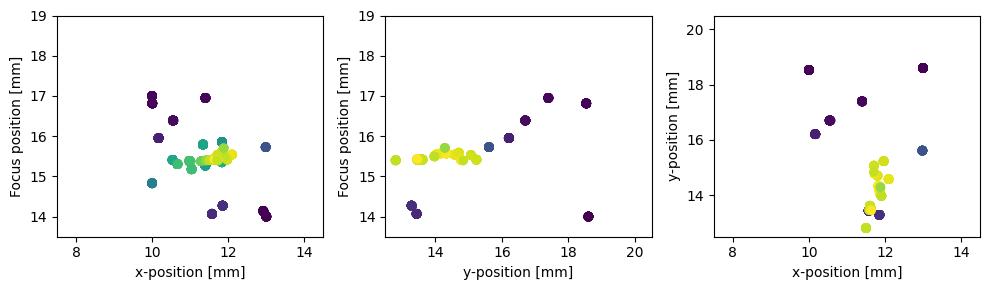

In [220]:

# importing matplot lib
import matplotlib.pyplot as plt
import numpy as np
 
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
 
# numpy array
x = np.linspace(-2, 2, 200)
 
# duration of the video
totaltime = 40
 
# matplot subplot
#fig, ax = plt.subplots()
fig, axs = plt.subplots(1,3,figsize=(10,3))

#plt.figure(figsize=(9, 1.5))
#img = plt.imshow(np.array([[0, max(-res.func_vals)]]))
#plt.gca().set_visible(False)
#cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#plt.colorbar(orientation="vertical", cax=cax)

#gs = GridSpec(1, 2, width_ratios = [0.9, 0.05])
#fig = plt.figure(figsize = (7, 7))
#ax = fig.add_subplot(gs[0])
#cbar_ax = fig.add_subplot(gs[1])
#fig.colorbar(fig, cax = cbar_ax)
# method to get frames
#cbvec=[]
def make_frame(t):
     
    # clear
    #ax.clear()
    
    #if len(cbvec)>0:
        #print('Hello')
        #fig.clear()
        #cb.remove() 
    # plotting line

    #ax.plot(x, np.sinc(x**2) + np.sin(x + 2 * np.pi / totaltime * t), lw = 3)
    #ax.set_ylim(-1.5, 2.5)
    #cb=plt.colorbar(axs[2].scatter(x_inputs,y_inputs,c=-res.func_vals))
    
    axs[0].scatter(x_inputs[:int(t+1)],focus_inputs[:int(t+1)],c=-res.func_vals[:int(t+1)], vmin=0, vmax=max(-res.func_vals))
    axs[0].set(xlabel='x-position [mm]', ylabel='Focus position [mm]')
    axs[0].set_ylim(13.5, 19) 
    axs[0].set_xlim(7.5, 14.5) 

    axs[1].scatter(y_inputs[:int(t+1)],focus_inputs[:int(t+1)],c=-res.func_vals[:int(t+1)], vmin=0, vmax=max(-res.func_vals))
    axs[1].set(xlabel='y-position [mm]', ylabel='Focus position [mm]')
    axs[1].set_ylim(13.5, 19) 
    axs[1].set_xlim(12.5, 20.5) 

    third=axs[2].scatter(x_inputs[:int(t+1)],y_inputs[:int(t+1)],c=-res.func_vals[:int(t+1)], vmin=0, vmax=max(-res.func_vals))
    axs[2].set(xlabel='x-position [mm]', ylabel='y-position [mm]')
    
    #cb=plt.colorbar(third)
    #cbvec.append(cb)  
    axs[2].set_ylim(12.5, 20.5) 
    axs[2].set_xlim(7.5, 14.5)
    
    fig.tight_layout()
    #plt.colorbar(orientation="vertical", cax=cax)
    
    #time.sleep(0.5)
    #cb.remove()
    # returning numpy image
    return mplfig_to_npimage(fig)

# creating animation
animation = VideoClip(make_frame, duration = totaltime)
#plt.colorbar(third) 
# displaying animation with auto play and looping
animation.ipython_display(fps = 1, loop = True, autoplay = True)


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


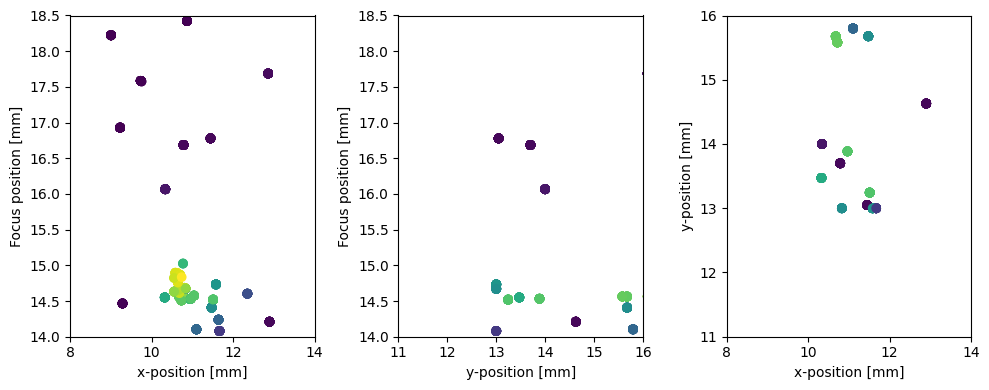

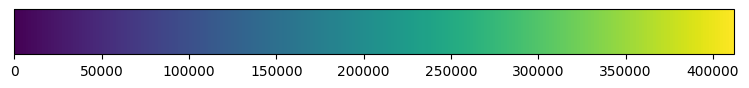

In [50]:
# importing matplot lib
import matplotlib.pyplot as plt
import numpy as np
 
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
 
# numpy array
x = np.linspace(-2, 2, 200)
 
# duration of the video
totaltime = 40
 
# matplot subplot
#fig, ax = plt.subplots()
fig, axs = plt.subplots(1,3,figsize=(10,4))

plt.figure(figsize=(9, 1.5))
img = plt.imshow(np.array([[0, max(-res.func_vals)]]))
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.3])
plt.colorbar(orientation="vertical", cax=cax)

#gs = GridSpec(1, 2, width_ratios = [0.9, 0.05])
#fig = plt.figure(figsize = (7, 7))
#ax = fig.add_subplot(gs[0])
#cbar_ax = fig.add_subplot(gs[1])
#fig.colorbar(fig, cax = cbar_ax)
# method to get frames
#cbvec=[]
def make_frame(t):
     
    # clear
    #ax.clear()
    
    #if len(cbvec)>0:
        #print('Hello')
        #fig.clear()
        #cb.remove() 
    # plotting line

    #ax.plot(x, np.sinc(x**2) + np.sin(x + 2 * np.pi / totaltime * t), lw = 3)
    #ax.set_ylim(-1.5, 2.5)
    #cb=plt.colorbar(axs[2].scatter(x_inputs,y_inputs,c=-res.func_vals))
    
    axs[0].scatter(x_inputs[:int(t+1)],focus_inputs[:int(t+1)],c=-res.func_vals[:int(t+1)], vmin=0, vmax=max(-res.func_vals))
    axs[0].set(xlabel='x-position [mm]', ylabel='Focus position [mm]')
    axs[0].set_ylim(14, 18.5) 
    axs[0].set_xlim(8, 14) 

    axs[1].scatter(y_inputs[:int(t+1)],focus_inputs[:int(t+1)],c=-res.func_vals[:int(t+1)], vmin=0, vmax=max(-res.func_vals))
    axs[1].set(xlabel='y-position [mm]', ylabel='Focus position [mm]')
    axs[1].set_ylim(14, 18.5) 
    axs[1].set_xlim(11, 16) 

    third=axs[2].scatter(x_inputs[:int(t+1)],y_inputs[:int(t+1)],c=-res.func_vals[:int(t+1)], vmin=0, vmax=max(-res.func_vals))
    axs[2].set(xlabel='x-position [mm]', ylabel='y-position [mm]')
    
    #cb=plt.colorbar(third)
    #cbvec.append(cb)  
    axs[2].set_ylim(11, 16) 
    axs[2].set_xlim(8, 14)
    
    fig.tight_layout()
    plt.colorbar(orientation="horizontal", cax=cax)
    
    #time.sleep(0.5)
    #cb.remove()
    # returning numpy image
    return mplfig_to_npimage(fig)

# creating animation
animation = VideoClip(make_frame, duration = totaltime)
#plt.colorbar(third) 
# displaying animation with auto play and looping
animation.ipython_display(fps = 1, loop = True, autoplay = True)

In [52]:
parameters=np.loadtxt("40iter412289maxsignal.txt")

In [53]:
print(parameters)

[[9.10000000e+01 8.74200000e+03 2.38770000e+04 5.00000000e+00
  0.00000000e+00 7.65500000e+03 1.36559000e+05 8.04300000e+03
  2.02520000e+05 1.14000000e+02 1.03900000e+04 1.31211000e+05
  2.99142000e+05 2.14569000e+05 6.83270000e+04 3.11276000e+05
  2.52385000e+05 1.81300000e+03 3.14132000e+05 3.38921000e+05
  3.02108000e+05 2.02537000e+05 2.78189000e+05 3.01660000e+05
  9.84750000e+04 3.08461000e+05 3.75872000e+05 3.61949000e+05
  3.43856000e+05 3.75380000e+05 3.67611000e+05 3.43372000e+05
  3.92836000e+05 4.05315000e+05 3.99286000e+05 3.87108000e+05
  3.90549000e+05 2.73942000e+05 3.78535000e+05 4.12289000e+05]
 [1.75844434e+01 1.66858257e+01 1.60666200e+01 1.69289981e+01
  1.82234872e+01 1.67786668e+01 1.41037809e+01 1.42099955e+01
  1.44077290e+01 1.84245390e+01 1.76873413e+01 1.42381084e+01
  1.45194509e+01 1.47329180e+01 1.40799023e+01 1.45624829e+01
  1.45503316e+01 1.44660494e+01 1.45635252e+01 1.45649369e+01
  1.45757227e+01 1.46706013e+01 1.45292795e+01 1.45320417e+01
  1.460

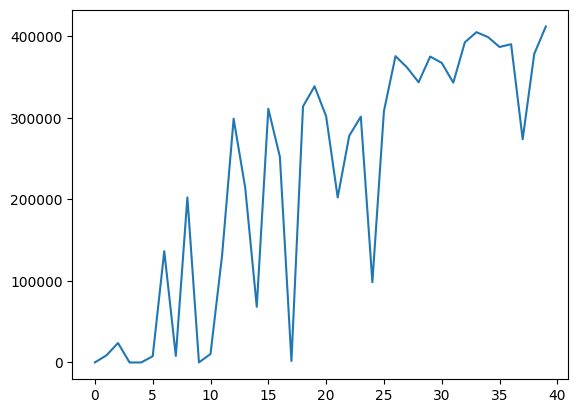

In [56]:
plt.plot(parameters[0])

t:   5%|▌         | 2/40 [06:08<1:56:38, 184.17s/it, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:   5%|▌         | 2/40 [06:09<1:56:59, 184.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


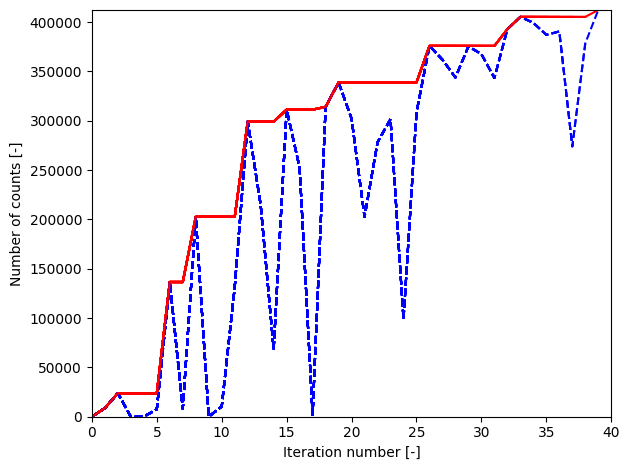

In [130]:
# importing matplot lib
import matplotlib.pyplot as plt
import numpy as np
 
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
 
# numpy array
x = np.linspace(-2, 2, 200)
 
# duration of the video
totaltime = 40

modifiedparams=[parameters[0][0]]
for i in range(1,len(parameters[0])-1):
    if parameters[0][i]>max(parameters[0][:i]):
        modifiedparams.append(parameters[0][i])
    else:
        modifiedparams.append(max(parameters[0][:i+1]))
modifiedparams.append((parameters[0][-1]))
# matplot subplot
fig, ax = plt.subplots()
#fig, axs = plt.subplots(1,3,figsize=(10,3))

def make_frame(t):

    plt.plot(parameters[0][:int(t+1)],"-b",linestyle="dashed")

    #ax.plot(x, np.sinc(x**2) + np.sin(x + 2 * np.pi / totaltime * t), lw = 3)
    #ax.set_ylim(-1.5, 2.5)
    #cb=plt.colorbar(axs[2].scatter(x_inputs,y_inputs,c=-res.func_vals))
    
    plt.plot(modifiedparams[:int(t+1)],"r")
    ax.set_ylim(0, max(parameters[0]))
    ax.set_xlim(0, 40)
    ax.set(xlabel='Iteration number [-]', ylabel='Number of counts [-]')
    fig.tight_layout()
    #plt.colorbar(orientation="vertical", cax=cax)
    
    #time.sleep(0.5)
    #cb.remove()
    # returning numpy image
    return mplfig_to_npimage(fig)

# creating animation
animation = VideoClip(make_frame, duration = totaltime)
#plt.colorbar(third) 
# displaying animation with auto play and looping
animation.ipython_display(fps = 1, loop = True, autoplay = True)

# Bin

In [48]:
Arduino_Shutter.CloseShutter(Device_to_Open_string)

'On was executed\r\n'

In [47]:
Arduino_Shutter.OpenShutter(Device_to_Open_string)

'Off was executed\r\n'

In [171]:
Standa_Vac_2.get_position()
Standa_Vac_2.move_to(231000)#355000)

'Stop moving at 231000'

In [170]:
Standa_Vac_2.get_position()
Standa_Vac_2.move_to(355000)

'Stop moving at 355001'

In [65]:
Standa_Vac_2.get_position()

'Position: 231000\nuPosition: 0\nEncPosition: 231000\n'

In [450]:
#AG_UC8_move_WP(1000) # 1.5 deg in 1000 steps 
for i in range(44):
    AG_UC8_move_WP(round(1*1000/1.5)) # 1.5 deg in 1000 steps 
    i=i+1
    time.sleep(1.5)
for i in range(44):
    AG_UC8_move_WP(round(-1*1000/1.5*(1-30/360))) # 1.5 deg in 1000 steps 
    i=i+1
    time.sleep(1.5)


In [51]:
AG_UC8_move_WP(round(-2*1000/1.5*(1-30/360)))#(round(-*1000/1.5))#*(1-30/360)

In [31]:
AG_UC8_move_WP(round(1*1000/1.5*(1+3/60)))

In [26]:
#newly aligned 23/10
SMC_move_focus(17)
SMC_move_x(13)
SMC_move_y(12.5)
Standa_Vac_2.move_to(231000)
#AG_UC8_move_WP(0)


'Stop moving at 231000'

In [63]:
SMC_move_focus(17)
SMC_move_x(14)
SMC_move_y(14.5)

In [204]:
posf=SMC_get_focus()
posx=SMC_get_x()
posy=SMC_get_y()
print(posf,posx,posy)

16.99999 9.8 12.49999


In [92]:
Arduino_Shutter.OpenShutter(Device_to_Open_string)
time.sleep(.1)
Arduino_Shutter.CloseShutter(Device_to_Open_string)

'Off was executed\r\n'

In [93]:
print(np.amax(acquire_data()))

352945634.0


In [295]:
data_scan = np.array([img])
print(np.shape(data_scan))

(1, 2052, 2048)


In [301]:
open_shutter_for_seconds(1)

In [56]:
shutter_thread = threading.Thread(target=open_shutter_for_seconds, args=(3,))

# Open Laser Shutter
shutter_thread.start()

In [184]:
stage_aduino.set_value("M","X",100000)

input: b'MX:100000\n'
b''


"b''"

In [188]:
stage_aduino.set_value("T","X",500)

input: b'TX:500\n'
b''


"b''"

In [187]:
spin_aduino.set_value("M","X",100000)

input: b'MX:100000\n'
b''


"b''"

In [134]:
Standa_Vac_1.get_position()

'Position: 288351\nuPosition: 0\nEncPosition: 288351\n'

In [137]:
Standa_Vac_1.move_to(288351)

'Stop moving at 288351'

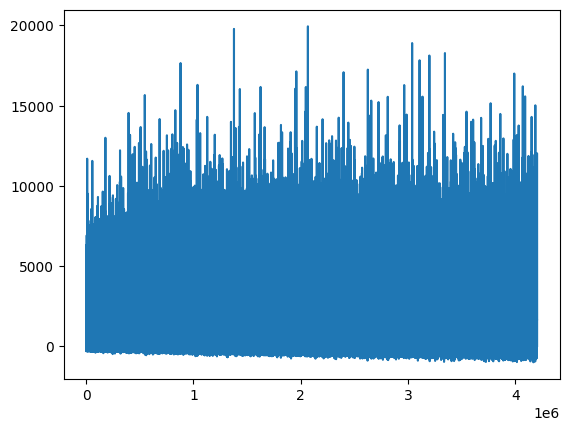

In [249]:
plt.plot(arr)


(10000.0, 200000.0)

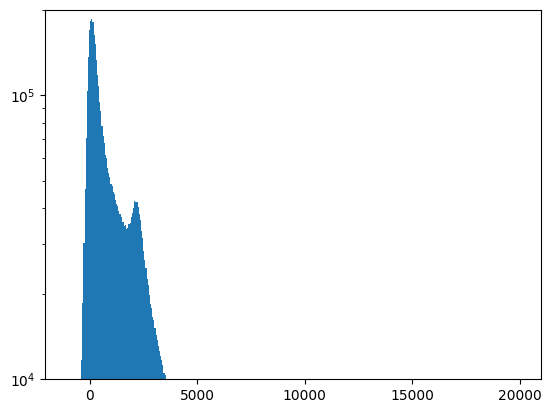

In [255]:
plt.hist(arr,bins=400)
plt.yscale('log')
plt.ylim([1e4,2e5])